(sec:oecd-bli)=
# OECD 국가의 삶의 만족도

__참고:__ 오렐리앙 제롱의 [<핸즈온 머신러닝(2판)>](https://github.com/ageron/handson-ml2) 
1장의 소스코드를 사용합니다.

## 주요 내용

1인당 [GDP(국내총생산)](https://ko.wikipedia.org/wiki/%EA%B5%AD%EB%82%B4%EC%B4%9D%EC%83%9D%EC%82%B0)와 삶의 만족도 사이의 
선형 관계를 예측하는 모델의 훈련과정을 자세하게 소개한다.

**참고**

핸즈온 머신러닝(3판)은 2020년 데이터를 사용하지만 여기서는 2판에서 사용하는 2015년도 데이터를 사용한다.
2020년 데이터는 [연습문제](https://colab.research.google.com/github/codingalzi/handson-ml3/blob/master/practices/practice_ml_landscape.ipynb)에서 다룬다.

## 기본 설정

파이썬 3.7 이상을 요구한다.

In [1]:
import sys
assert sys.version_info >= (3, 7)

넘파이와 판다스 모듈은 필수적이다.

In [2]:
# 모듈: 넘파이와 판다스
import numpy as np
import pandas as pd

머신러닝 모델은 무작위 선택을 실행한다.
실행 결과를 매번 동일하게 유지하기 위해 랜덤 시드를 지정한다.

In [3]:
# 랜덤 시드 설정: 동일한 실행 결과 얻기
np.random.seed(42)

그래프 출력에 필요한 기본 설정을 지정한다.

In [4]:
# 그래프 출력 설정
import matplotlib.pyplot as plt

plt.rc('font', size=12)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

판다스 기본 설정

In [5]:
pd.set_option('display.max_columns', None)

## 선형회귀 모델 구현

선형회귀 모델의 구현과정은 일반적으로 아래 다섯 단계로 이루어진다.

1. 문제 정의
1. 데이터 구하기
1. 데이터 적재, 정제, 전처리
1. 모델 선택과 훈련
1. 모델 활용

### 1단계: 문제 정의

어느 국가의 1인당 GDP가 알려졌을 때 해당 국가의 삶의 만족도를 예측하는 모델을 구현해야 한다.

### 2단계: 데이터 구하기

모델 훈련에 사용되는 훈련 셋은 __입력__ 데이터 셋과 
__타깃__<font size="2">target</font> 데이터 셋으로 구분된다.
모델 훈련은 입력 데이터와 타깃 데이터 사이의 관계를 가장 적절하게 
묘사하는 모델을 학습하는 과정이다.

1인당 GDP와 삶의 만족도 사이의 관계를 가장 적절하게 묘사하는 모델의 훈련에
사용되는 훈련 셋은 다음과 같다.

- 입력 데이터
    - 국가별 1인당 GDP 데이터
    - 출처: [국제통화기금(IMF)](https://ko.wikipedia.org/wiki/%EA%B5%AD%EC%A0%9C_%ED%86%B5%ED%99%94_%EA%B8%B0%EA%B8%88#:~:text=%EA%B5%AD%EC%A0%9C%20%ED%86%B5%ED%99%94%20%EA%B8%B0%EA%B8%88(%E5%9C%8B%E9%9A%9B%E9%80%9A%E8%B2%A8,%EC%9C%84%EC%9E%84%EB%B0%9B%EC%9D%80%20%EA%B5%AD%EC%A0%9C%20%EA%B8%B0%EA%B5%AC%EC%9D%B4%EB%8B%A4.)의 
['세계 경제전망 데이터베이스'](http://goo.gl/j1MSKe).
- 타깃 데이터
    - [OECD](https://ko.wikipedia.org/wiki/%EA%B2%BD%EC%A0%9C%ED%98%91%EB%A0%A5%EA%B0%9C%EB%B0%9C%EA%B8%B0%EA%B5%AC)
    회원 국가별 '삶의 만족도'(life satisfaction) 데이터
    - 출처: OECD의 
        ['더 나은 삶의 지수'(BLI, Better Life Index)](https://stats.oecd.org/Index.aspx?DataSetCode=BLI).

훈련 데이터 구하는 과정을 여기서는 
특정 서버에 저장된 다음 두 개의 csv 파일을 다운로드하는 것으로 대체한다.

* gdp_per_capita_2015.csv
    - IMF(국제통화기금)에 제공하는 1인당 국내총생산 데이터(GDP) 데이터
* oecd_bli_2015.csv
    - 2015년도 기준 OECD 국가들의 '더 나은 삶의 지수'(BLI) 데이터

최종적으로 아래 표와 같은 데이터를 생성해야 하는데 언급된 데이터 파일을 다운로드 하면 전혀
다른 모양의 데이터가 파일에 포함되어 있다.
이어지는 3단계에서 원본 데이터 파일에서 아래 모양의 표를 어떻게 유도해낼 수 있는지
자세히 설명한다. 
설명 이해가 어렵다면 4단계로 넘아가도 선형회귀 모델의 훈련 과정을 이해할 수 있다.
하지만 훈련 보다는 데이터를 준비하는 과정이 일반적으로 더 중요하기에 3단계를 
최대한 이해하도록 노력할 것을 권장한다.

| 국가 | 1인당 GDP(미국 달러) | 삶의 만족도 |
| :--- | :--- | :--- |
| 헝가리 | 12,240 | 4.9 |
| 한국 | 27,195 | 5.8 |
| 프랑스 | 37,675 | 6.5 |
| 호주 | 50,9672 | 7.3 |
| 미국 | 55,805 | 7.2 |

### 3단계: 데이터 적재, 정제, 전처리

컴퓨터에 저장된 또는 다운로드된 데이터는 일반적으로 바로 모델 훈련에 사용할 수 없으며, 
데이터 적재, 데이터 정제, 데이터 전처리 등의 과정을 거쳐야 비로소 모델 훈련에 활용될 수 있다.

* __데이터 적재__(data loading): 서버에 존재하거나 컴퓨터에 저장되어 있는 파일을 
    특정 자료형의 값으로 불러오는 과정

* __데이터 정제__(data cleaning): 적재된 데이터 셋에 포함된 오류, 부정확한 값, 
    누락된 값, 상관없는 값 등을 제거, 수정, 보완하는 과정

* __데이터 전처리__(data preprocessing): 정제된 데이터 셋을 모델 훈련에 적절한 형식으로 변환하거나
    적절한 내용의 데이터를 추가하거나 삭제하는 과정

#### 1인당 GDP 데이터 적재, 정제, 전처리

2015년 기준 국가별 1인당 GDP 관련 데이터가 저장되어 있는 서버 주소는 다음과 같다.

In [6]:
datapath = "https://raw.githubusercontent.com/codingalzi/handson-ml3/master/notebooks/data/lifesat/"

판다스의 `read_csv()` 함수는 지정된 경로에 저장된 csv 을 판다스의 데이터프레임 객체로 적재한다.
적재할 때 사용되는 옵션 인자는 다음과 같다.

- `thousands=','`: 1000단위로 쉼표 찍기
- `delimiter='\t'`: 탭(tab)으로 열 구분
- `encoding='latin1'`: 인코딩 방식 지정. 파일에서 사용된 'C&ocirc;te d'Ivoire'(코트디브와르)와 같은 특수 알파벳을 사용하는 국가명 처리 용도임.
- `na_values="n/a"`: 결측치를 'NaN'으로 처리.

In [7]:
gdp_per_capita_2015 = pd.read_csv(datapath + "gdp_per_capita_2015.csv", 
                             thousands=',', 
                             delimiter='\t',
                             encoding='latin1', 
                             na_values="n/a")

총 190개 국가의 1인당 GDP 정보를 담고 있다.

In [8]:
gdp_per_capita_2015

,Country,Subject Descriptor,Units,Scale,Country/Series-specific Notes,2015,Estimates Start After
0,Afghanistan,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",599.994,2013.0
1,Albania,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",3995.383,2010.0
2,Algeria,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4318.135,2014.0
3,Angola,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4100.315,2014.0
4,Antigua and Barbuda,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",14414.302,2011.0
...,...,...,...,...,...,...,...
185,Vietnam,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",2088.344,2012.0
186,Yemen,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",1302.940,2008.0
187,Zambia,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",1350.151,2010.0
188,Zimbabwe,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",1064.350,2012.0


국가명을 행 인덱스로 지정한다.

In [9]:
gdp_per_capita_2015.set_index("Country", inplace=True)

gdp_per_capita_2015

,Subject Descriptor,Units,Scale,Country/Series-specific Notes,2015,Estimates Start After
Country,,,,,,
Afghanistan,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",599.994,2013.0
Albania,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",3995.383,2010.0
Algeria,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4318.135,2014.0
Angola,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4100.315,2014.0
Antigua and Barbuda,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",14414.302,2011.0
...,...,...,...,...,...,...
Vietnam,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",2088.344,2012.0
Yemen,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",1302.940,2008.0
Zambia,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",1350.151,2010.0


이어서 1인당 GDP 데이터임을 명시하기 위해 열 이름 `"2015"`를 `"GDP per capita"`로 변경한다.

In [10]:
gdp_per_capita_2015.rename(columns={"2015": "GDP per capita"}, inplace=True) 

gdp_per_capita_2015.head()

,Subject Descriptor,Units,Scale,Country/Series-specific Notes,GDP per capita,Estimates Start After
Country,,,,,,
Afghanistan,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",599.994,2013.0
Albania,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",3995.383,2010.0
Algeria,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4318.135,2014.0
Angola,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4100.315,2014.0
Antigua and Barbuda,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",14414.302,2011.0


#### 삶의 만족도 데이터 적재, 정제, 전처리

OECD 국가별 삶의 만족도 데이터는 '더 나은 삶의 지수' 데이터 파일에 포함되어 있다. 
따라서 먼저 해당 csv 파일을 판다스의 데이터프레임 객체로 불러온 후에 
삶의 만족도와 관련된 내용을 추출하는 과정을 밟는다.

- `pandas.read_csv()` 함수는 지정한 경로에 저장되어 있는 csv 파일을 다운로드하여 바로 데이터프레임 객체를
생성한다.

In [11]:
oecd_bli = pd.read_csv(datapath + "oecd_bli_2015.csv", thousands=',')

생성된 데이터프레임의 모양은 다음과 같다.

In [12]:
oecd_bli.shape

(3292, 17)

처음 5행를 살펴보자.

In [13]:
oecd_bli.head()

,LOCATION,Country,INDICATOR,Indicator,MEASURE,Measure,INEQUALITY,Inequality,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,AUS,Australia,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,1.1,E,Estimated value
1,AUT,Austria,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,1.0,NaN,NaN
2,BEL,Belgium,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,2.0,NaN,NaN
3,CAN,Canada,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,0.2,NaN,NaN
4,CZE,Czech Republic,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,0.9,NaN,NaN


국가별 삶의 만족도는 `'Life satisfaction'`이라는 측정지표(`'Indicator'`) 열(column)의
특성값 중에 하나이다. 
총 24개 측정지표가 사용되며 그중에 하나임을 확인할 수 있다.

In [14]:
oecd_bli.Indicator.unique()

array(['Dwellings without basic facilities', 'Housing expenditure',
       'Rooms per person', 'Household net adjusted disposable income',
       'Household net financial wealth', 'Employment rate',
       'Job security', 'Long-term unemployment rate', 'Personal earnings',
       'Quality of support network', 'Educational attainment',
       'Student skills', 'Years in education', 'Air pollution',
       'Water quality', 'Consultation on rule-making', 'Voter turnout',
       'Life expectancy', 'Self-reported health', 'Life satisfaction',
       'Assault rate', 'Homicide rate',
       'Employees working very long hours',
       'Time devoted to leisure and personal care'], dtype=object)

24개 측정지표 중 하나임을 확인한다.

In [15]:
oecd_bli.Indicator.unique().shape

(24,)

In [16]:
'Life satisfaction' in oecd_bli.Indicator.unique()

True

그런데 삶의 만족도와 관련된 행이 OECD 회원국의 수인 37보다 많다.
이는 삶의 만족도와 관련해서 데이터의 중복이 있다는 것을 의미한다. 

In [17]:
mask = oecd_bli.Indicator == 'Life satisfaction'
oecd_bli[mask].shape

(179, 17)

무엇이 중복되었는지를 알아내기 위해 
OECD 회원국가별로 `'Indicator'` 열에 포함된 24개 측정지표에 해당하는 값(value)만을 따로 추출해보자.
즉, ['더 나은 삶의 지수'(BLI, Better Life Index) 자료](https://stats.oecd.org/Index.aspx?DataSetCode=BLI)에서
볼 수 있는 아래 테이블 이미지와 같은 데이터프레임을 생성하고자 한다. 

- 행: OECD 회원국(`Country`)
- 열: 측정지표(`Indicator`)
- 항목 값: 국가별 지표 수치(`Value`)

<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/pydata/master/notebooks/images/oecd_bli.png"/></div>

이를 위해 국가명(`'Country'` 열의 항목)을 행의 인덱스 이름으로, 
`'Indicator'`의 항목을 열의 인덱스 이름으로 사용하는 데이터프레임을 생성한다.
해당 열과 항목에 해당하는 값은 `'Value'` 열에 포함된 값을 사용한다.

그런데 OECD의 원본 파일에는 각 측정지표의 값으로 국가별 소득 불평등(`'INEQUALITY'`)과 관련된 다섯 가지 
기준에 따라 다른 값이 포함되어 있다(위 이미지 좌상단 화살표 참조).

| 기준   | 기호 | 대상     |
| :---  | :---| :---    |
| Total | TOT | 전체 인구 |
| Men   | MN  | 남성     |
| Wemen | WMN | 여성     |
| High  | HGH | 상위 소득 |
| Low   | LW  | 하위 소득 |

In [18]:
oecd_bli.INEQUALITY.unique()

array(['TOT', 'MN', 'WMN', 'HGH', 'LW'], dtype=object)

각 기준별 행의 개수는 다음과 같다.

In [19]:
arr1 = oecd_bli.INEQUALITY.unique()

sum = 0
for ineq in arr1:
    num_lines = (oecd_bli['INEQUALITY'] == ineq).sum()
    print(f"{ineq:>3}:\t{num_lines}행")

    sum += num_lines # 총 라인 수

print(f"\n 총:\t{sum}행")

TOT:	888행
 MN:	881행
WMN:	881행
HGH:	328행
 LW:	314행

 총:	3292행


전체 인구를 대상으로 하는 `TOT` 기준에 포함된 데이터만 추출한다.

In [20]:
oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]

앞서 확인한 대로 총 888개의 행으로 이루어진 데이터프레임이다.

In [21]:
oecd_bli.shape

(888, 17)

여기서 `37 * 24 = 888`이 성립함에 주목해야 한다. 
왜냐하면 이는 위데이터프레임이 37개 OECD 회원국별로 24개의 지표를 조사한 데이터를 포함한다는 의미이기 때문이다.
또한 측정된 지표값은 `'Value'` 열에 포함되어 있다.

이제 데이터프레임 객체의 `pivot()` 메서드를 이용하여 
`'Indicator'` 의 항목에 대한 각 국가별 수치만을 추출하기 위해
국가명(`'Country'` 열의 항목)을 행의 인덱스 이름으로, 
`'Indicator'`의 항목을 열의 인덱스 이름으로 사용하면서
해당 행과 열의 항목에는 `'Value'` 열에 포함된 값을 사용하는 
데이터프레임을 아래와 같이 생성할 수 있다.

In [22]:
oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")

이제 총 37개 국가의 측정지표별 수치를 확인하면 다음과 같다.

In [23]:
oecd_bli

Indicator,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,Housing expenditure,Job security,Life expectancy,Life satisfaction,Long-term unemployment rate,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education
Country,,,,,,,,,,,,,,,,,,,,,,,,
Australia,13.0,2.1,10.5,1.1,76.0,14.02,72.0,0.8,31588.0,47657.0,20.0,4.8,82.1,7.3,1.08,50449.0,92.0,2.3,85.0,512.0,14.41,93.0,91.0,19.4
Austria,27.0,3.4,7.1,1.0,83.0,7.61,72.0,0.4,31173.0,49887.0,21.0,3.9,81.0,6.9,1.19,45199.0,89.0,1.6,69.0,500.0,14.46,75.0,94.0,17.0
Belgium,21.0,6.6,4.5,2.0,72.0,4.57,62.0,1.1,28307.0,83876.0,21.0,5.0,80.5,6.9,3.88,48082.0,94.0,2.2,74.0,509.0,15.71,89.0,87.0,18.9
Brazil,18.0,7.9,4.0,6.7,45.0,10.41,67.0,25.5,11664.0,6844.0,21.0,4.6,73.7,7.0,1.97,17177.0,90.0,1.6,69.0,402.0,14.97,79.0,72.0,16.3
Canada,15.0,1.3,10.5,0.2,89.0,3.94,72.0,1.5,29365.0,67913.0,21.0,6.4,81.5,7.3,0.90,46911.0,92.0,2.5,89.0,522.0,14.25,61.0,91.0,17.2
Chile,46.0,6.9,2.0,9.4,57.0,15.42,62.0,4.4,14533.0,17733.0,18.0,4.4,78.9,6.7,1.59,22101.0,86.0,1.2,59.0,436.0,14.41,49.0,73.0,16.5
Czech Republic,16.0,2.8,6.8,0.9,92.0,6.98,68.0,0.8,18404.0,17299.0,26.0,4.1,78.2,6.5,3.12,20338.0,85.0,1.4,60.0,500.0,14.98,59.0,85.0,18.1
Denmark,15.0,3.9,7.0,0.9,78.0,2.03,73.0,0.3,26491.0,44488.0,24.0,5.6,80.1,7.5,1.78,48347.0,95.0,1.9,72.0,498.0,16.06,88.0,94.0,19.4
Estonia,9.0,5.5,3.3,8.1,90.0,3.30,68.0,4.8,15167.0,7680.0,19.0,5.2,76.5,5.6,3.82,18944.0,89.0,1.5,54.0,526.0,14.90,64.0,79.0,17.5


참고로 대한민국의 측정지표별 수치는 다음과 같다(위 이미지 중간의 파란띠로 구분된 영역 참조).

In [24]:
oecd_bli.loc['Korea']

Indicator
Air pollution                                   30.00
Assault rate                                     2.10
Consultation on rule-making                     10.40
Dwellings without basic facilities               4.20
Educational attainment                          82.00
Employees working very long hours               18.72
Employment rate                                 64.00
Homicide rate                                    1.10
Household net adjusted disposable income     19510.00
Household net financial wealth               29091.00
Housing expenditure                             16.00
Job security                                     3.20
Life expectancy                                 81.30
Life satisfaction                                5.80
Long-term unemployment rate                      0.01
Personal earnings                            36354.00
Quality of support network                      72.00
Rooms per person                                 1.40
Self-reported heal

알파벳 순으로 첫 5개 국가의 삶의 만족도는 `"Life satisfaction"` 열(column)에서 확인할 수 있다.

In [25]:
oecd_bli["Life satisfaction"].head()

Country
Australia    7.3
Austria      6.9
Belgium      6.9
Brazil       7.0
Canada       7.3
Name: Life satisfaction, dtype: float64

#### 데이터 병합

앞서 살펴본 대로 1인당 GDP 데이터는 OECD 회원국 이외의 국가 데이터도 포함되어 있다.
OECD 회원국으로 제한해서 1인당 GDP와 삶의 만족도 사이의 관계를 파악하기 위해
앞서 구한 두 개의 데이터프레임을 하나로 병합한다.

- 판다스의 `merge()` 함수를 이용한다. 
- OECD 회원국들만 대상으로 하기 위해 
    `left_index=True`와 `right_index=True`로 설정한다.

In [26]:
oecd_country_stats = pd.merge(left=gdp_per_capita_2015['GDP per capita'],
                              right=oecd_bli['Life satisfaction'], 
                              left_index=True, right_index=True)

In [27]:
oecd_country_stats

,GDP per capita,Life satisfaction
Country,,
Australia,50961.865,7.3
Austria,43724.031,6.9
Belgium,40106.632,6.9
Brazil,8669.998,7.0
Canada,43331.961,7.3
Chile,13340.905,6.7
Czech Republic,17256.918,6.5
Denmark,52114.165,7.5
Estonia,17288.083,5.6


1인당 GDP와 삶의 만족도 사이의 선형 관계를 눈으로 확인하기 위해 국가를 
1인당 GDP 기준 오름차순으로 정렬시킨다.

In [28]:
oecd_country_stats.sort_values(by="GDP per capita", inplace=True)

oecd_country_stats

,GDP per capita,Life satisfaction
Country,,
Brazil,8669.998,7.0
Mexico,9009.280,6.7
Russia,9054.914,6.0
Turkey,9437.372,5.6
Hungary,12239.894,4.9
Poland,12495.334,5.8
Chile,13340.905,6.7
Slovak Republic,15991.736,6.1
Czech Republic,17256.918,6.5


#### 추가 설정

선형회귀 모델을 훈련시킬 때 발생할 수 있는 과대적합 문제를 설명하기 위해
고의로 7개 국가의 데이터를 데이터 셋에서 제외시키고 훈련 시킬 때와 
그렇지 않을 때를 비교하고자 한다.

제외 대상 국가는 브라질, 멕시코, 칠레, 체코, 노르웨이, 스위스, 룩셈부르크 이다.
데이터프레임에서 아래 인덱스를 이용하여 7개 국가를 제외시키고 훈련을 시킬 것이다.

In [29]:
omitted_indices = [0, 1, 6, 8, 33, 34, 35]

kept_indices = list( set(range(36)) - set(omitted_indices) )

제외된 7개 국가의 1인당 GDP와 삶의 만족도 데이터는 다음과 같다.

In [30]:
missing_data = oecd_country_stats.iloc[omitted_indices]

missing_data

,GDP per capita,Life satisfaction
Country,,
Brazil,8669.998,7.0
Mexico,9009.280,6.7
Chile,13340.905,6.7
Czech Republic,17256.918,6.5
Norway,74822.106,7.4
Switzerland,80675.308,7.5
Luxembourg,101994.093,6.9


7개 국가를 제외한 국가들의 1인당 GDP와 삶의 만족도 데이터를 지정한다.

In [31]:
sample_data = oecd_country_stats.iloc[kept_indices] 

### 4단계: 모델 선택과 훈련

#### 선형 관계 확인

아래 코드는 앞서 언급된 7개 국가의 데이터를 제외한 국가들의 1인당 GDP와 
삶의 만족도 사이의 관계를 산점도로 나타낸다.
선형관계를 잘 보여주는 다음 다섯 개 국가는 빨간색 점으로 표시한다.

* 헝가리(Hungary)
* 대한민국(Korea)
* 프랑스(France)
* 호주(Australia)
* 미국(United States)

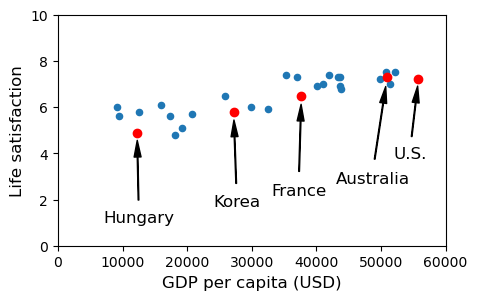

In [32]:
# 7개 국가를 제외한 국가들의 데이터 산점도
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.axis([0, 60000, 0, 10])

# 언급된 5개 국가명과 좌표
position_text = {
    "Hungary": (7000, 1),
    "Korea": (24000, 1.7),
    "France": (33000, 2.2),
    "Australia": (43000, 2.7),
    "United States": (52000, 3.8),
}

# 5개 국가는 좌표를 이용하여 빨강색 점으로 표기
for country, pos_text in position_text.items():
    pos_data_x, pos_data_y = sample_data.loc[country]            # 5개 국가의 지표
    
    # 5개 국가명 표기
    country = "U.S." if country == "United States" else country  # 미국은 U.S. 로 표기
    
    # 화살표 그리기
    plt.annotate(country, xy=(pos_data_x, pos_data_y), 
                 xytext=pos_text,
                 arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5) )
    
    # 5개 국가 산점도 그리기: 빨강색 점
    plt.plot(pos_data_x, pos_data_y, "ro")

# x 축 제목 새롭게 지정
plt.xlabel("GDP per capita (USD)")

plt.show()

언급된 5개 국가의 1인당 GDP와 삶의 만족도를 데이터에서 직접 확인하면 다음과 같다.

In [33]:
sample_data.loc[list(position_text.keys())]

,GDP per capita,Life satisfaction
Country,,
Hungary,12239.894,4.9
Korea,27195.197,5.8
France,37675.006,6.5
Australia,50961.865,7.3
United States,55805.204,7.2


위 산점도에 따르면 1인당 GDP와 삶의 만족도가 어느 정도 선형 관계에 있는 것처럼 보인다.

#### 선형회귀 모델

직선처럼 y 축의 값이 x 축의 값에 선형적으로 의존하는 관계를 __선형관계__라 하며,
그런 선형관계를 함수로 구현하는 모델을 __선형회귀 모델__(linear regression model)이라 한다.
선형회귀 모델은 직선을 나타내는 1차 함수의 그래프로 표현되며,
직선은 절편(y축과 만나는 점)과 기울기 두 개의 값에 의해 정해진다.

예를 들어, 1인당 GDP와 삶의 만족도 사이에 다음 선형 관계가 성립하도록 하는
절편 $\theta_0$ 와 기울기 $\theta_1$ 을 구해야 한다.

$$
\text{'삶의만족도'} = \theta_0 + \theta_1 \cdot \text{'1인당GDP'}
$$

$\theta_0$ 와 $\theta_1$ 처럼 모델 구현에 사용되는 값들을 모델의 
__파라미터__<font size="2">parameter</font>라 하며,
모델의 파라미터를 찾아내는 것이 머신러닝 모델훈련의 핵심이다. 

#### 사이킷런 라이브러리 활용

**사이킷런**<font size="2">scikit-learn</font> 라이브러리는 머신러닝에서 사용되는 
다양한 모델을 제공한다.
선형회귀의 경우 `LinearRegression` 클래스의 객체를 생성하여 훈련시키면 
최적의 절편과 기울기를 계산해준다. 

사이킷런의 모델을 지정하고 훈련시키는 과정은 다음과 같다.

**과정 1: 모델 지정**

사이킷런(sklearn) 패키지의 `linear_model` 모듈에 포함된 `LinearRegression` 클래스의 객체를 선언한다.
선언된 모델은 아직 어떤 훈련도 하지 않은 상태이다. 

In [34]:
from sklearn.linear_model import LinearRegression

lin1 = LinearRegression()

**과정 2: 훈련 셋 지정**

입력 데이터 셋은 x 축에, 타깃 데이터 셋은 y 축에 해당한다.

* 입력 데이터: 1인당 GDP
* 타깃 데이터: 삶의 만족도

입력 데이터와 타깃 데이터를 2차원 어레이로 지정한다. 
사이킷런의 선형회귀 모델이 2차원 어레이 형식의 입력 데이터 셋과 타깃 데이터 셋을 요구한다.
넘파이의 `c_` 함수를 활용해서 차원을 늘려준다.

In [35]:
Xsample = np.c_[sample_data["GDP per capita"]]
ysample = np.c_[sample_data["Life satisfaction"]]

변환 전의 처음 5개 데이터는 다음과 같다.

In [36]:
np.array(sample_data["GDP per capita"][:5])

array([ 9054.914,  9437.372, 12239.894, 12495.334, 15991.736])

2차원 어레이로 변환 된 입력 데이터의 처음 5개는 다음과 같다.

In [37]:
Xsample[:5]

array([[ 9054.914],
       [ 9437.372],
       [12239.894],
       [12495.334],
       [15991.736]])

타깃 데이터 또한 마찬가지이다.

In [38]:
ysample[:5]

array([[6. ],
       [5.6],
       [4.9],
       [5.8],
       [6.1]])

**과정 3: 모델 훈련**


선형 모델의 `fit()` 메서드를 지정된 입력 데이터 셋과 타깃 터이터 셋을 
인자로 사용해서 호출하면
최적의 $\theta_0$와 $\theta_1$ 파라미터를 찾는 훈련이 실행되며
훈련이 종료되면 최적의 파라미터가 업데이트된 객체 자신이 반환된다.

In [39]:
lin1.fit(Xsample, ysample)

LinearRegression()

훈련된 모델이 알아낸 최적 선형 모델의 절편과 기울기는 아래 두 속성에 저장된다.

* `intercept_[0]`: 직선의 절편
* `coef_[0]`: 직선의 기울기

In [40]:
t0, t1 = lin1.intercept_[0], lin1.coef_[0][0]

print(f"절편:\t {t0}")
print(f"기울기:\t {t1}")

절편:	 4.853052800266435
기울기:	 4.9115445891584845e-05


구해진 기울기와 절편을 이용하여 산점도와 함께 직선을 그리면 다음과 같다.

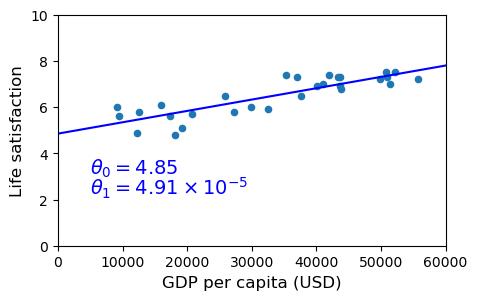

In [41]:
# 산점도
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.xlabel("GDP per capita (USD)")
plt.axis([0, 60000, 0, 10])

# 직선 그리기
X=np.linspace(0, 60000, 1000)
plt.plot(X, t0 + t1*X, "b")

# 직선의 절편과 기울기 정보 명시
plt.text(5000, 3.1, r"$\theta_0 = 4.85$", fontsize=14, color="b")
plt.text(5000, 2.2, r"$\theta_1 = 4.91 \times 10^{-5}$", fontsize=14, color="b")

plt.show()

### 5단계: 모델 활용

한 국가의 1인당 GDP가 알려졌을 때 
훈련된 모델에 포함된 $\theta_0$ 와 $\theta_1$ 을 이용하여 
해당 국가의 삶의 만족도를 예측한다. 
예를 들어, OECD에 속하지 않는 키프러스(Cyprus)의 1인당 GDP를 이용하여
키프러스 국민의 삶의 만족도를 예측한다.

In [42]:
cyprus_gdp_per_capita_2015 = gdp_per_capita_2015.loc["Cyprus"]["GDP per capita"]

cyprus_gdp_per_capita_2015

22587.49

훈련된 모델의 `predict()` 메서드가 아래 식을 이용하여 삶의 만족도를 계산한다. 

$$
\theta_0 + \theta_1 \cdot \text{'1인당GDP'}
$$

키프러스 국민의 삶의 만족도는 5.96 정도로 예측된다.

In [43]:
cyprus_predicted_life_satisfaction = lin1.predict([[cyprus_gdp_per_capita_2015]])[0, 0]

cyprus_predicted_life_satisfaction

5.962447443188149

## 머신러닝의 모델 훈련의 어려움

머신러닝 알고리즘을 훈련시키다보면 다양한 어려움에 부딪힌다. 
여기서는 선형회귀 모델이 훈련셋에 민감하게 반응하는 것을 보이고자 한다.

### 훈련 데이터 추가

앞서 제외시킨 7개 국가의 데이터를 포함해서 선형회귀 모델을 훈련시켜 보자.
제외된 7개 국가의 데이터는 다음과 같다.

* 브라질(Brazil)
* 멕시코(Mexico)
* 칠레(Chile)
* 체코(Czech Repulic)
* 노르웨이(Norway)
* 스위스(Switzerland)
* 룩셈부르크(Luxembourg)

In [44]:
missing_data

,GDP per capita,Life satisfaction
Country,,
Brazil,8669.998,7.0
Mexico,9009.280,6.7
Chile,13340.905,6.7
Czech Republic,17256.918,6.5
Norway,74822.106,7.4
Switzerland,80675.308,7.5
Luxembourg,101994.093,6.9


아래 좌표는 7개 국가명을 아래 그래프에서 표기할 때 사용할 좌표이다.

In [45]:
position_text2 = {
    "Brazil": (1000, 9.0),
    "Mexico": (11000, 9.0),
    "Chile": (25000, 9.0),
    "Czech Republic": (35000, 9.0),
    "Norway": (60000, 3),
    "Switzerland": (72000, 3.0),
    "Luxembourg": (90000, 3.0),
}

7개 국가를 포함한 전체 훈련 데이터 셋을 이용하여 훈련한 결과를
7개 국가를 제외했을 때의 훈련 결과와 비교한다.

* 검정 실선: 7개 국가 포함 예측 선형 모델
* 파랑 점선: 7개 국가 제외 예측 선형 모델

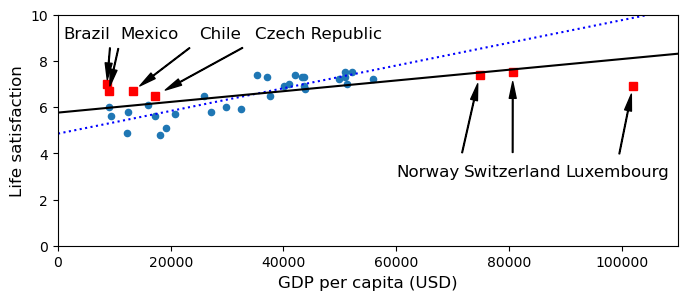

In [46]:
# 7개 국가를 제외한 국가들의 산점도 (파랑색 점)
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(8,3))
plt.axis([0, 110000, 0, 10])

# 7개 국가 산점도(빨강 점)
for country, pos_text in position_text2.items():
    pos_data_x, pos_data_y = missing_data.loc[country]
    # 7개 국가명 표기
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "rs")

# 7개 국가 제외 예측 선형 모델 그래프 (파랑 점선)
X=np.linspace(0, 110000, 1000)
plt.plot(X, t0 + t1*X, "b:")

# 7개 국가 포함 선형회귀 모델 훈련 및 예측
lin_reg_full = LinearRegression()
Xfull = np.c_[oecd_country_stats["GDP per capita"]]
yfull = np.c_[oecd_country_stats["Life satisfaction"]]
lin_reg_full.fit(Xfull, yfull)

# 7개 국가 포함 예측 선형 모델 그래프(검정 실선)
t0full, t1full = lin_reg_full.intercept_[0], lin_reg_full.coef_[0][0]
X = np.linspace(0, 110000, 1000)
plt.plot(X, t0full + t1full * X, "k")
plt.xlabel("GDP per capita (USD)")

plt.show()

결론적으로 7개 국가를 포함하는 경우와 그렇지 않은 경우
상당히 다른 선형회귀 모델이 훈련된다.
즉, 모델 훈련이 훈련 데이터 셋에 민감하게 반응하는 **과대 적합** 현상이 발생한다.
이런 의미에서 선형회귀 모델은 1인당 GDP와 삶의 만족도 사이의 관계를 모델링 하기에 부적절하다.